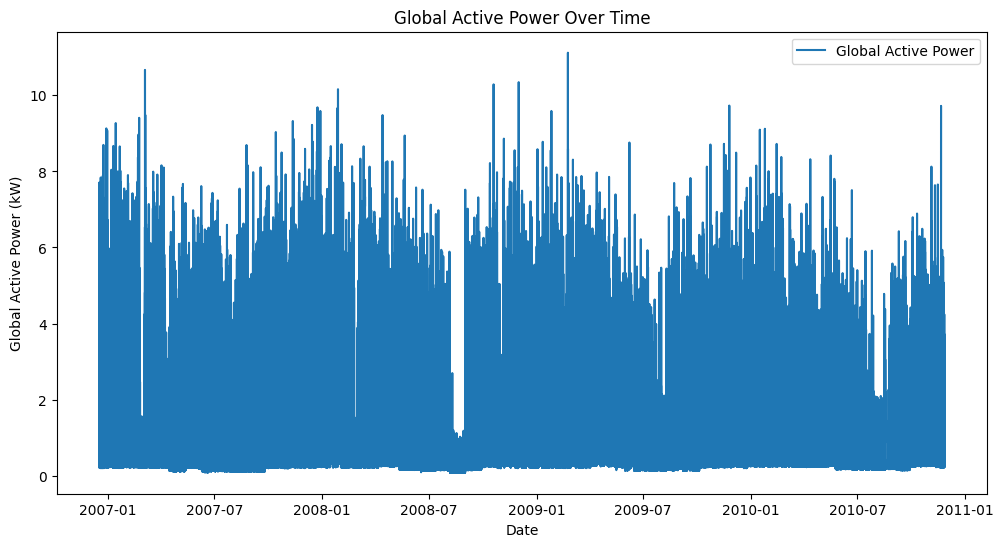

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the cleaned dataset
data_path = '../data/cleaned_household_power_consumption.csv'
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')

data = df[['Global_active_power']]

# plotting the data before modeling
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [7]:
# Selecting only relevant columns for prediction
# Including other features such as Voltage, Global_intensity, and sub-metering values
features = ['Global_active_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df = df[features]

# training and testing data split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Feature scaling
# fit scaler on training data only, and transform both train and test
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#converting scaled data back to DataFrames for easier handling
train_scaled = pd.DataFrame(train_scaled, columns=features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=features, index=test.index)

print("Scaled Training Data:")
print(train_scaled.head())

print("\nScaled Testing Data:")
print(test_scaled.head())

Scaled Training Data:
                     Global_active_power   Voltage  Global_intensity  \
DateTime                                                               
2006-12-16 17:24:00             0.374796  0.376090          0.377593   
2006-12-16 17:25:00             0.478363  0.336995          0.473029   
2006-12-16 17:26:00             0.479631  0.326010          0.473029   
2006-12-16 17:27:00             0.480898  0.340549          0.473029   
2006-12-16 17:28:00             0.325005  0.403231          0.323651   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                             
2006-12-16 17:24:00             0.0          0.0125        0.548387  
2006-12-16 17:25:00             0.0          0.0125        0.516129  
2006-12-16 17:26:00             0.0          0.0250        0.548387  
2006-12-16 17:27:00             0.0          0.0125        0.548387  
2006-12-16 17:28:00             0.0          0.0125  